In [94]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from Data_definition import Data
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
T  = 600
dt = 0.01

t_span = (0, T)
t_eval = np.arange(*t_span, dt)

In [96]:
# res = scipy.optimize.root(lambda y: dydt(1000*T, y, Data),
#                           x0 = [-60, -60, 0.5, 0.5, 0.5, 0.5, 0.5, 0])
# print(res.x)
# print(dydt(0, res.x, Data))
# y_init = res.x

# y_init[2] = 0.0
# y_init[0] = -70

y_init = np.array([Data['initial_VS'],
                   Data['initial_VD'],
                   Data['initial_w' ],
                   Data['initial_n' ],
                   Data['initial_h' ],
                   Data['initial_c' ],
                   Data['initial_q' ],
                   Data['initial_Ca']])


sol = scipy.integrate.solve_ivp(fun = lambda t, y: dydt(t, y, Data),
                                t_span = t_span,
                                y0 = y_init,
                                t_eval = t_eval,
                                method = 'RK45',
                                atol = 1e-6,
                                rtol = 1e-6,
                                vectorized=False)

if not sol.success:
    raise RuntimeError("ODE solver failed: " + sol.message)
else:
    print("ODE solver succeeded")

ODE solver succeeded


In [97]:
# Extract all quantities of interest

time = sol.t

VS, VD, w, n, h, c, q, Ca = sol.y

derivatives = dydt_vectorized(time, sol.y, Data, return_full=False)
dVSdt, dVDdt, dwdt, dndt, dhdt, dcdt, dqdt, dCadt = derivatives
dVsdt_norm, dVddt_norm, dwdt_norm, dndt_norm, dhdt_norm, dcdt_norm, dqdt_norm, dCadt_norm = \
    derivatives / np.max(np.abs(derivatives), axis=1)[:, None]

IS, ID, IDS, INa, IK, ISL, ICa, IKC, IKAHP, IDL = \
    computeCurrents_vectorized(time, sol.y, Data)

_, _, _, _, _, _, _, _, pieces = dydt_vectorized(time, sol.y, Data, return_full=True)

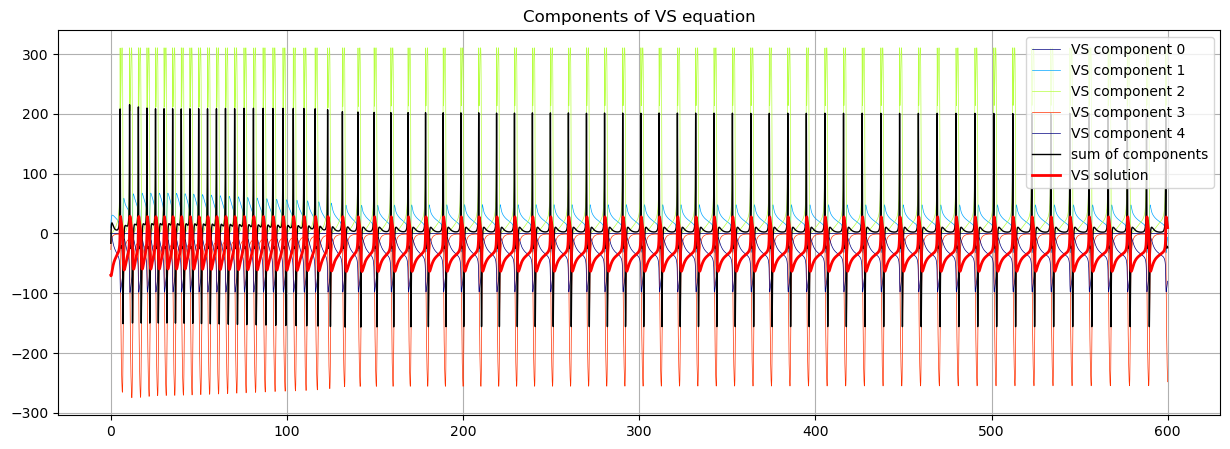

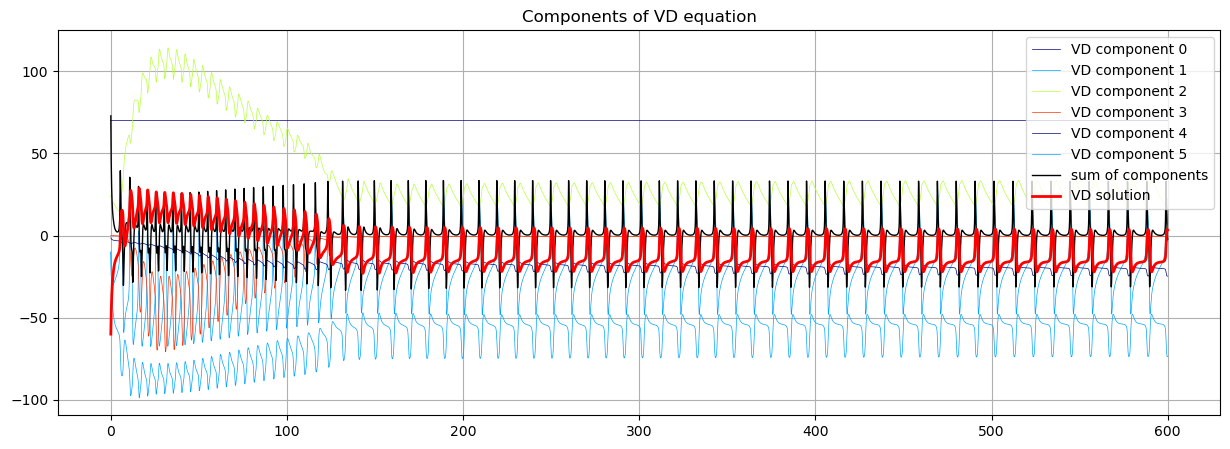

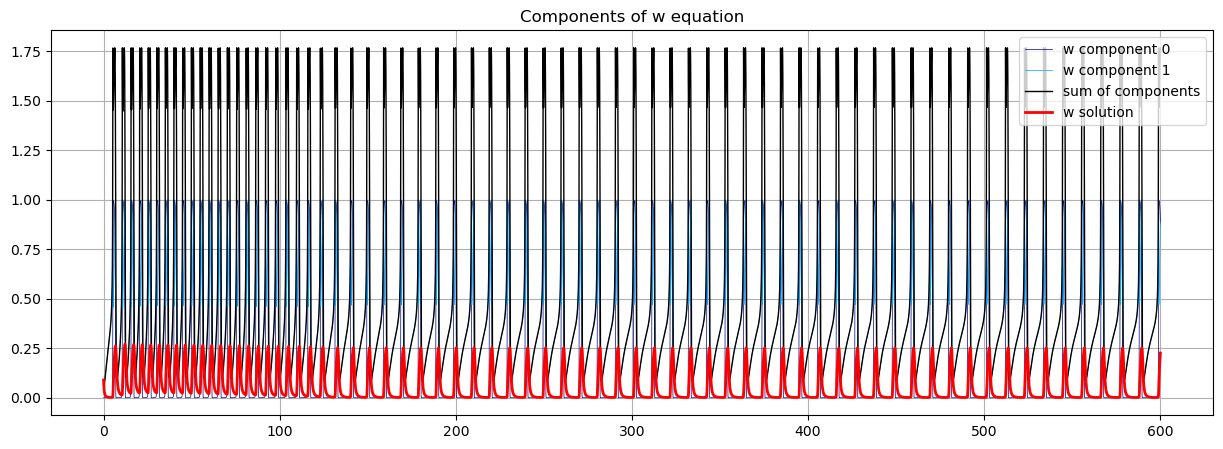

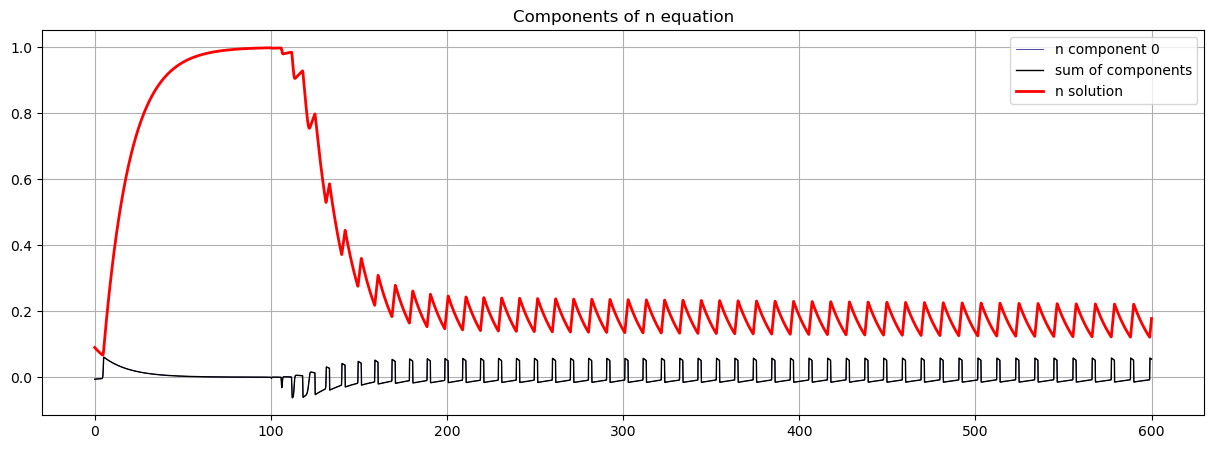

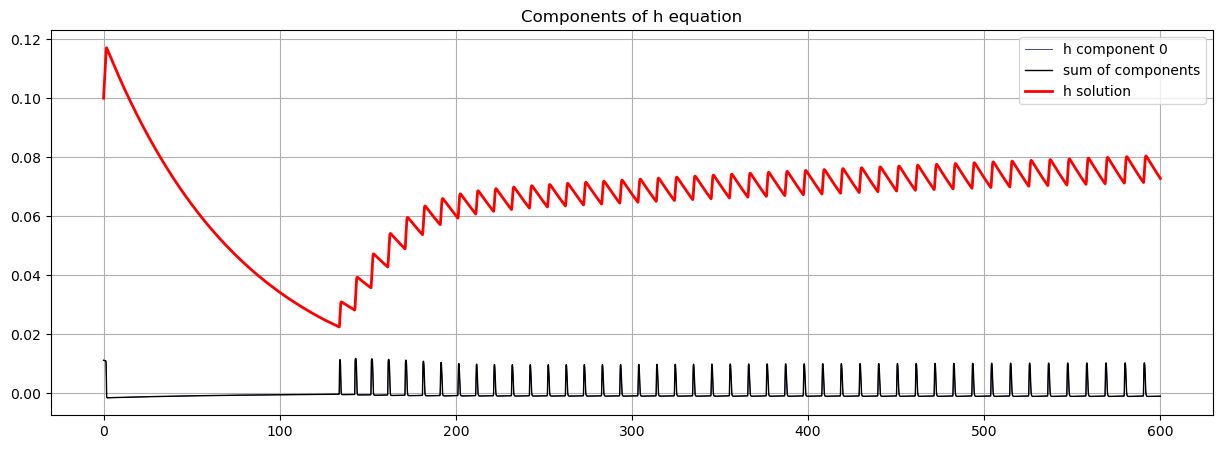

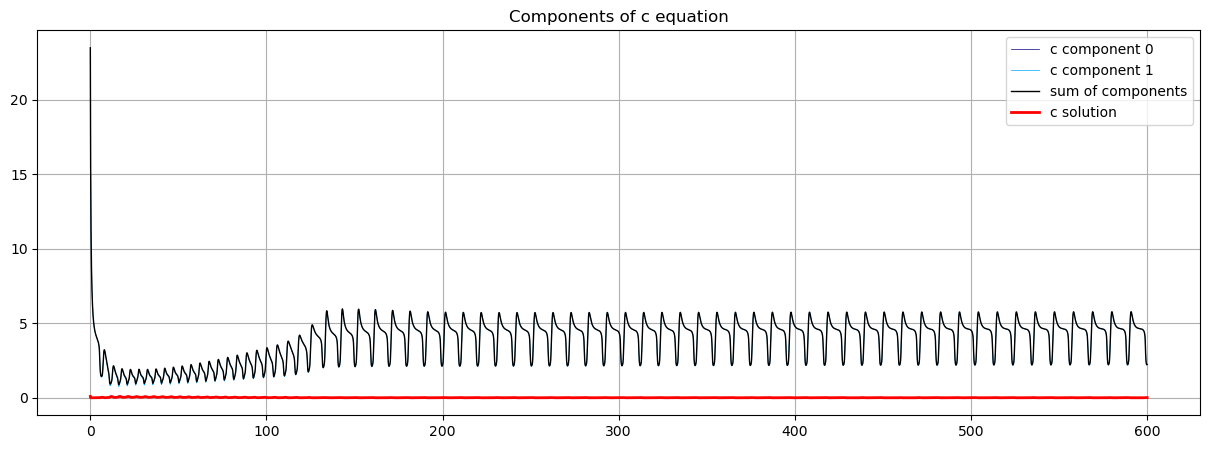

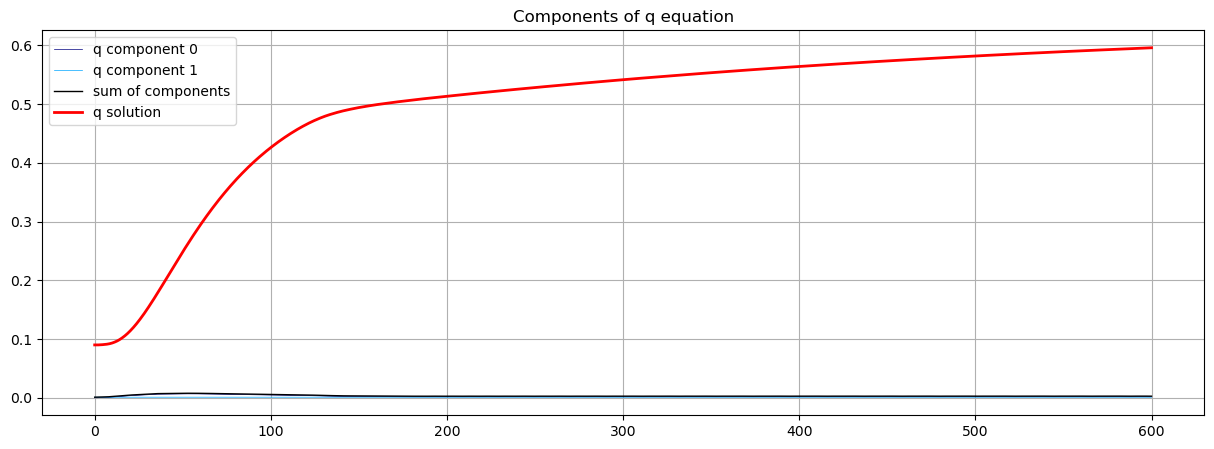

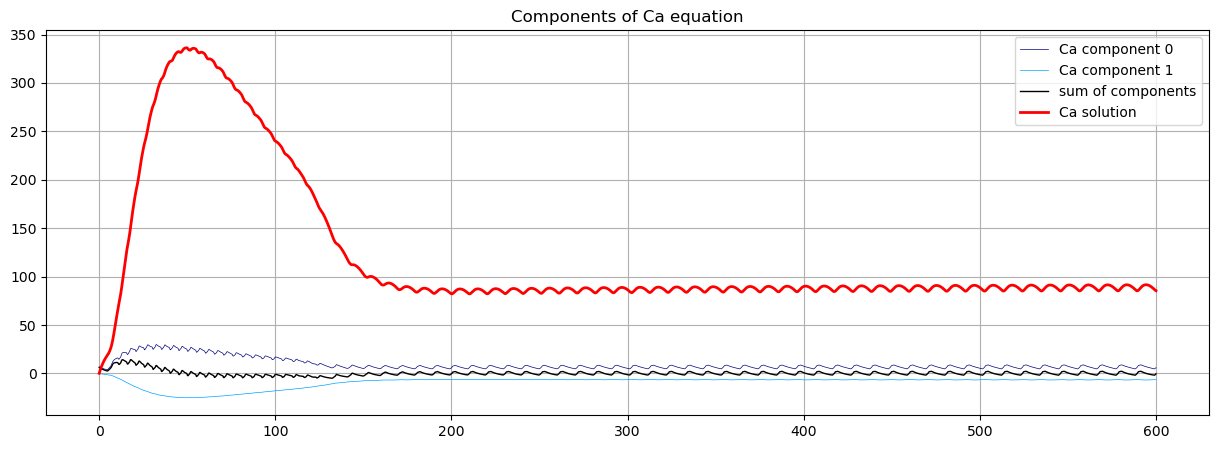

In [98]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 8))
figsize = (15, 5)
variables = ['VS', 'VD', 'w', 'n', 'h', 'c', 'q', 'Ca']

for j in range(len(pieces)):
    plt.figure(figsize=figsize)
    plt.title("Components of " + variables[j] + " equation")
    for i in range(len(pieces[j])):
        plt.plot(time, pieces[j][i, :], label=variables[j] + " component " + str(i), color=colors[2*i%8], linewidth=0.5)
    plt.plot(time, np.sum(pieces[j], axis=0), label="sum of components", color='black', linewidth=1, linestyle='-')
    plt.plot(time, sol.y[j, :], label=variables[j] + " solution", color='red', linewidth=2)
    plt.legend()
    plt.grid()
    plt.show()


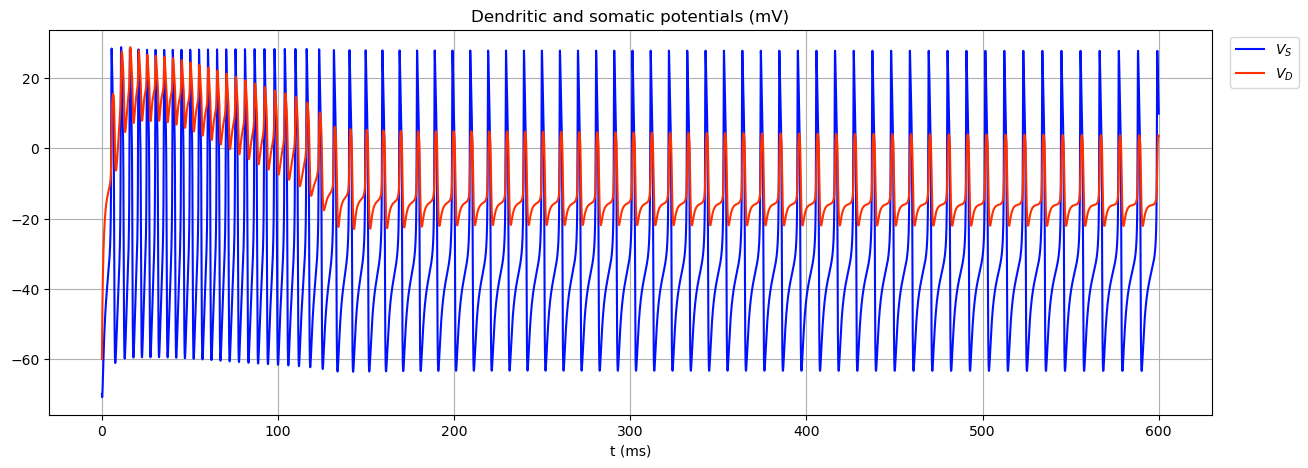

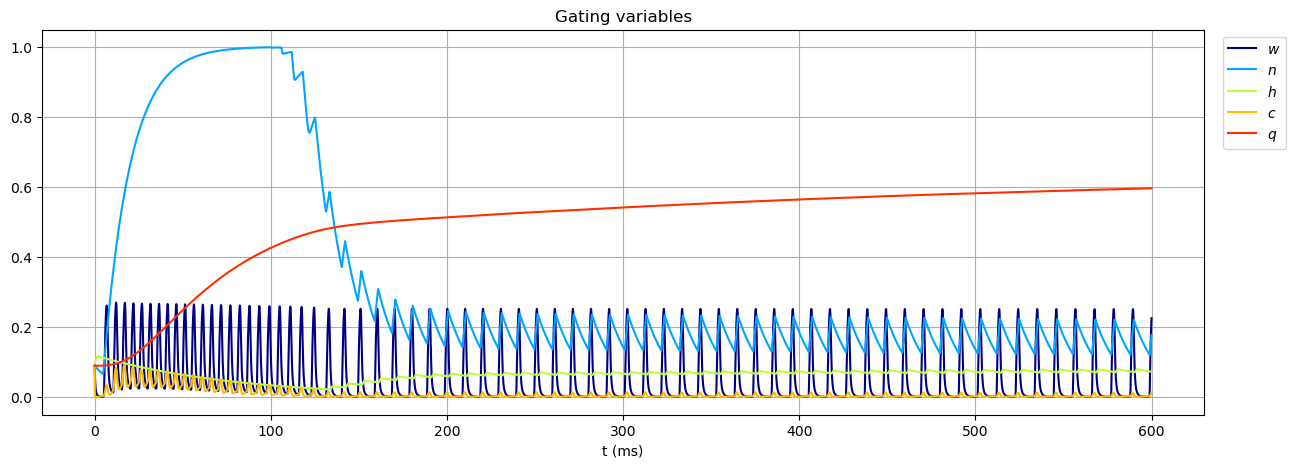

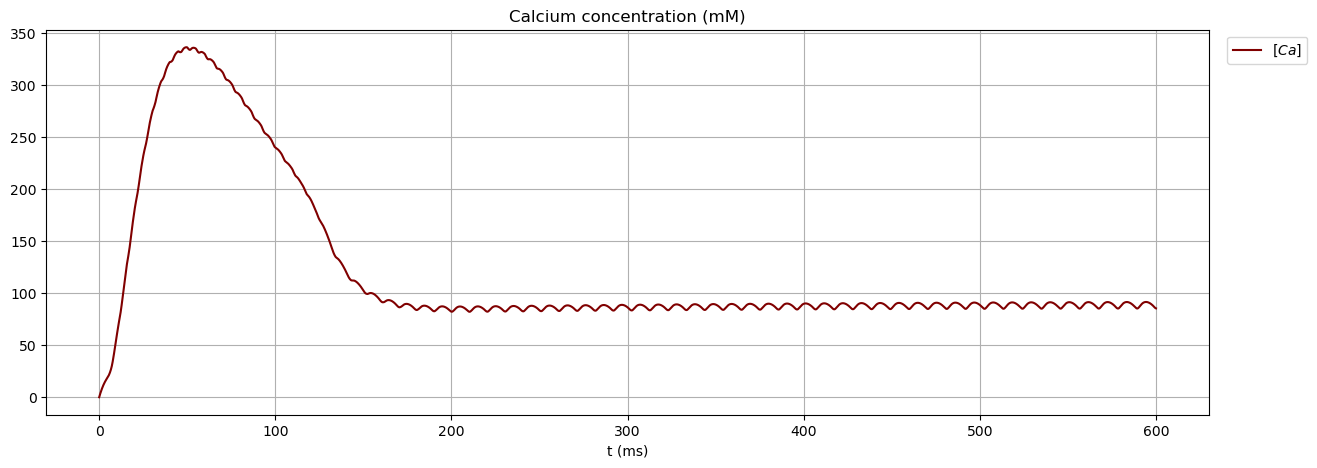

In [99]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 8))
figsize = (15, 5)

plt.figure(figsize=figsize)
plt.plot(time, VS, label='$V_S$', color=colors[1])
plt.plot(time, VD, label='$V_D$', color=colors[6])
plt.xlabel('t (ms)')
plt.title('Dendritic and somatic potentials (mV)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

plt.figure(figsize=figsize)
plt.plot(time, w, label='$w$', color=colors[0])
plt.plot(time, n, label='$n$', color=colors[2])
plt.plot(time, h, label='$h$', color=colors[4])
plt.plot(time, c, label='$c$', color=colors[5])
plt.plot(time, q, label='$q$', color=colors[6])
plt.xlabel('t (ms)')
plt.title('Gating variables')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

plt.figure(figsize=figsize)
plt.plot(time, Ca, label='$[Ca]$', color=colors[7])
plt.xlabel('t (ms)')
plt.title('Calcium concentration (mM)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
plt.show()

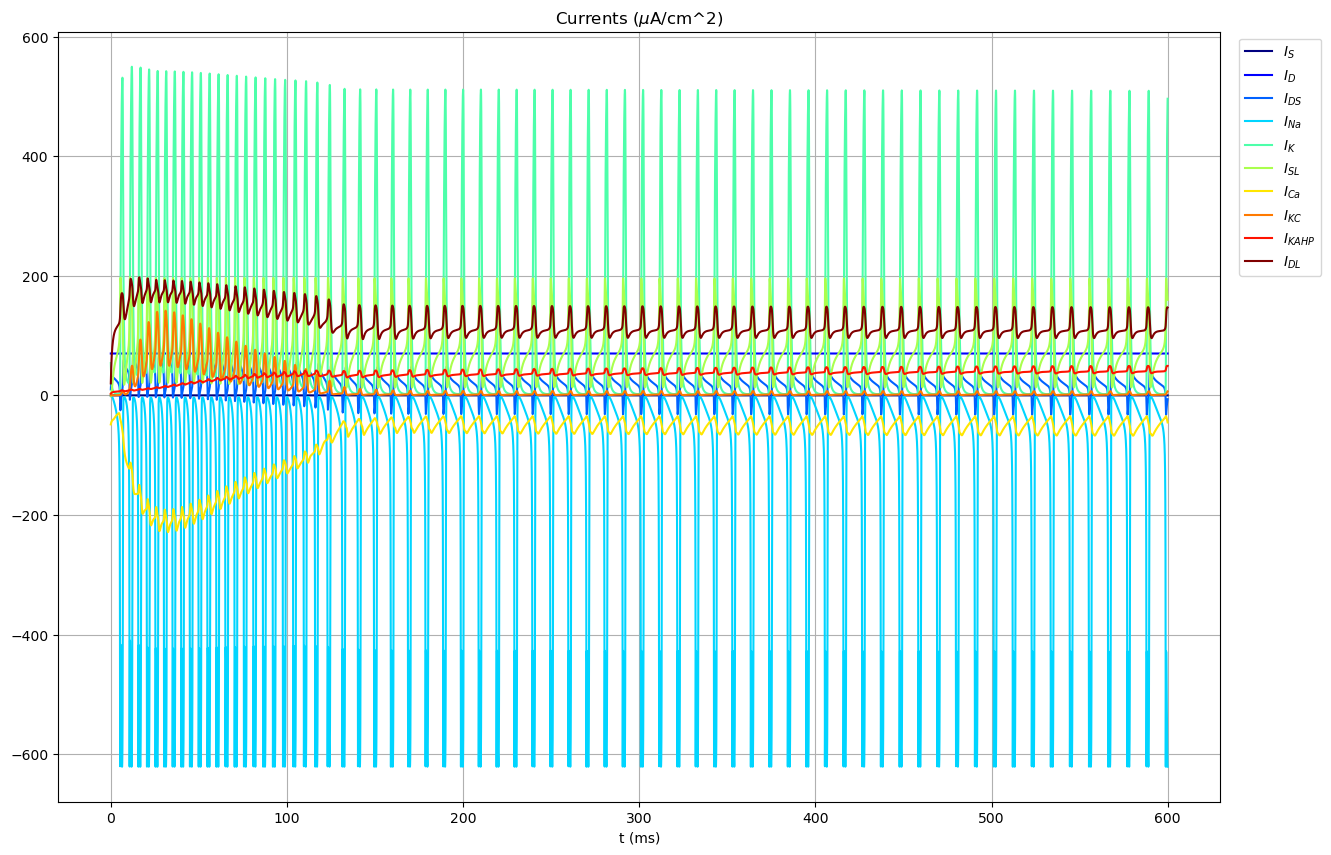

In [100]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 10))
figsize=(15, 10)

plt.figure(figsize=figsize)
plt.plot(time, IS   , label='$I_{S}$'   , color=colors[0])
plt.plot(time, ID   , label='$I_{D}$'   , color=colors[1])
plt.plot(time, IDS  , label='$I_{DS}$'  , color=colors[2])
plt.plot(time, INa  , label='$I_{Na}$'  , color=colors[3])
plt.plot(time, IK   , label='$I_{K}$'   , color=colors[4])
plt.plot(time, ISL  , label='$I_{SL}$'  , color=colors[5])
plt.plot(time, ICa  , label='$I_{Ca}$'  , color=colors[6])
plt.plot(time, IKC  , label='$I_{KC}$'  , color=colors[7])
plt.plot(time, IKAHP, label='$I_{KAHP}$', color=colors[8])
plt.plot(time, IDL  , label='$I_{DL}$'  , color=colors[9])
plt.xlabel('t (ms)')
plt.title(r'Currents ($\mu$A/cm^2)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
# plt.ylim(-150, 150)
plt.show()

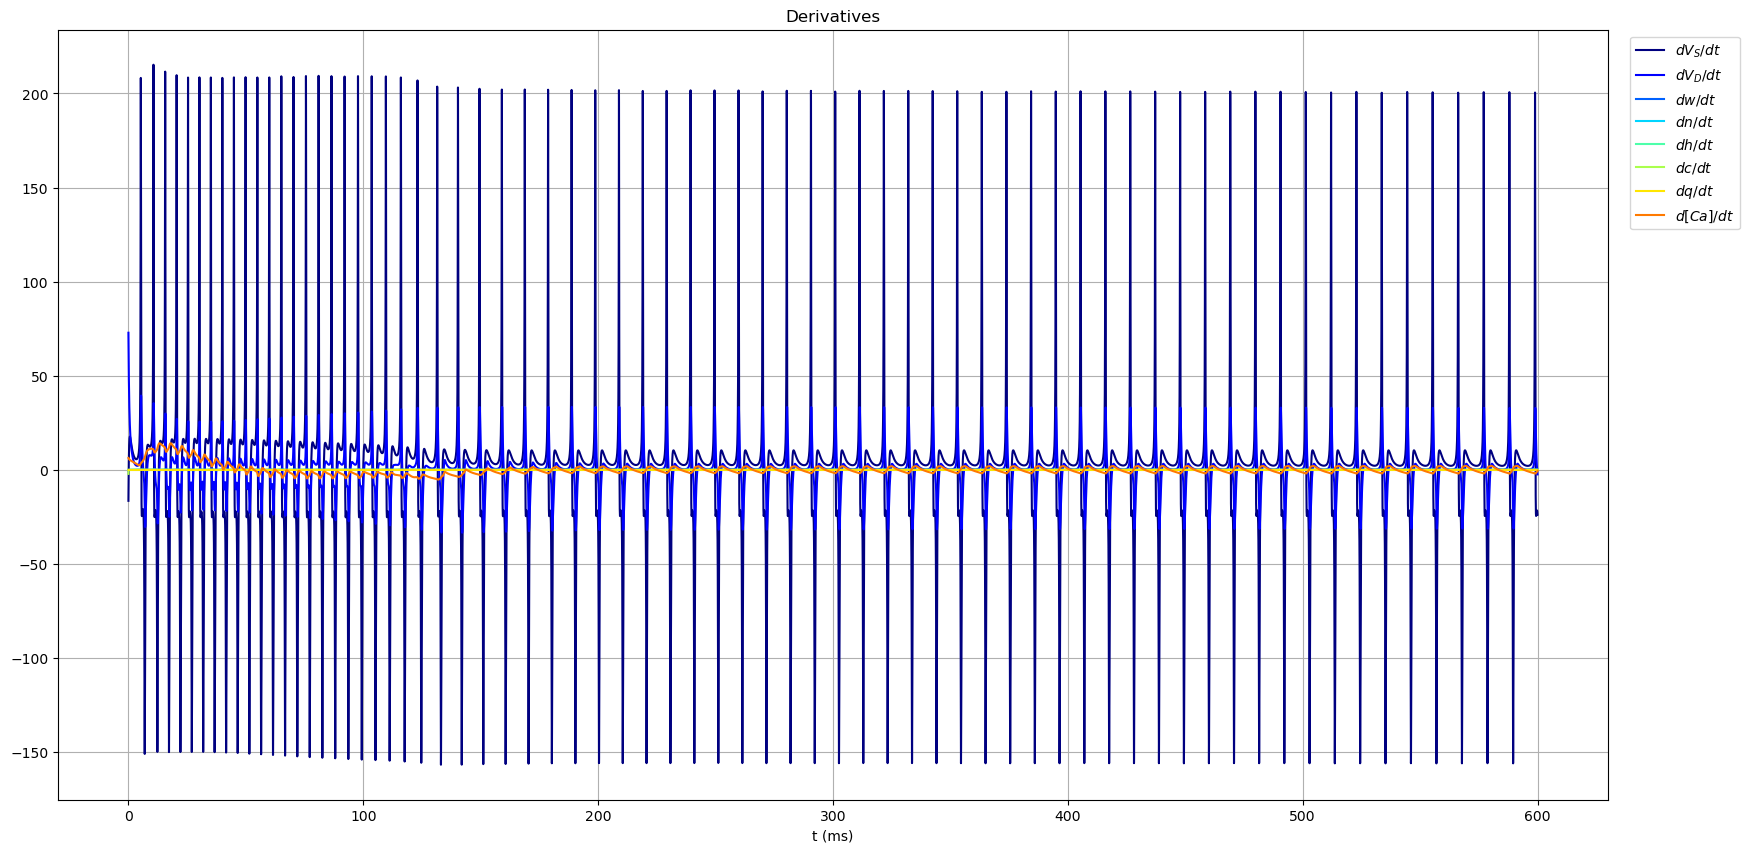

In [101]:
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 10))
figsize=(20, 10)

plt.figure(figsize=figsize)
plt.plot(time, dVSdt, label='$dV_S/dt$' , color=colors[0])
plt.plot(time, dVDdt, label='$dV_D/dt$' , color=colors[1])
plt.plot(time, dwdt , label='$dw/dt$'   , color=colors[2])
plt.plot(time, dndt , label='$dn/dt$'   , color=colors[3])
plt.plot(time, dhdt , label='$dh/dt$'   , color=colors[4])
plt.plot(time, dcdt , label='$dc/dt$'   , color=colors[5])
plt.plot(time, dqdt , label='$dq/dt$'   , color=colors[6])
plt.plot(time, dCadt, label='$d[Ca]/dt$', color=colors[7])
plt.xlabel('t (ms)')
plt.title('Derivatives')
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
plt.grid()
# plt.ylim(-150, 150)
plt.show()

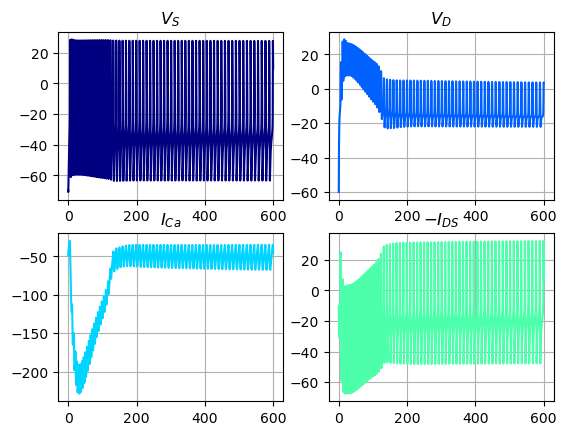

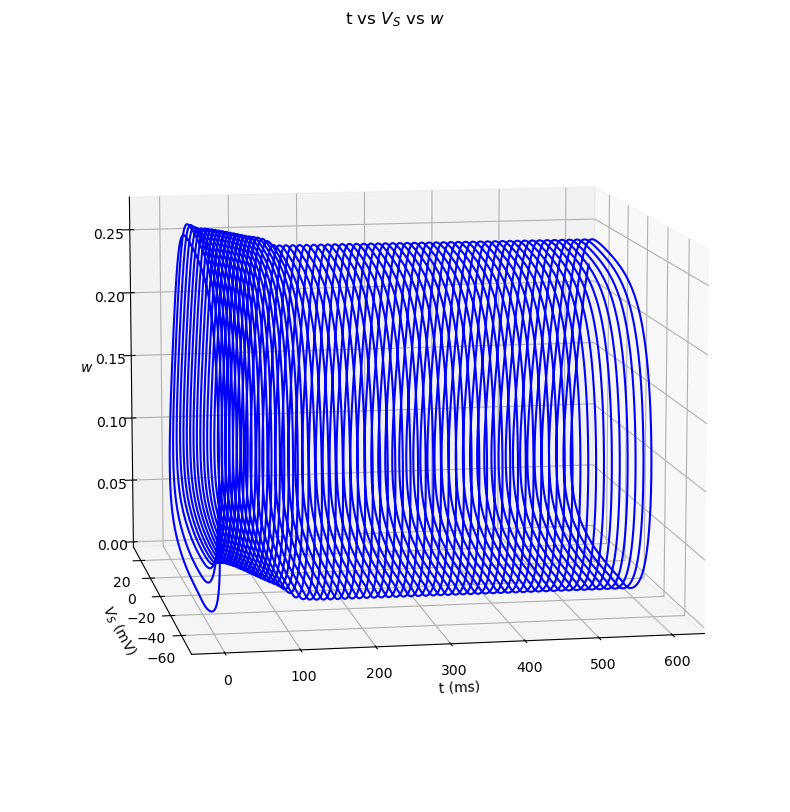

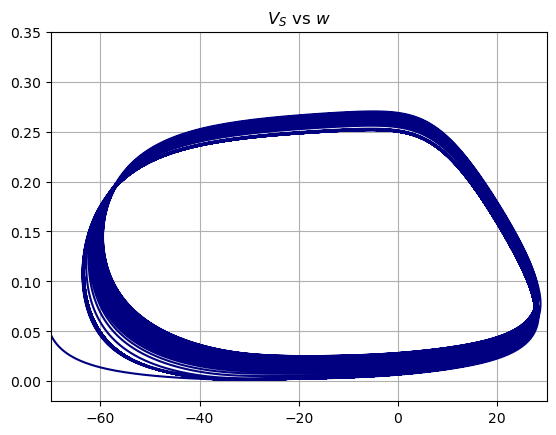

In [102]:
plt.subplot(2, 2, 1)
plt.plot(time, VS, color=colors[0])
plt.title('$V_S$')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, VD, color=colors[2])
plt.title('$V_D$')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(time, ICa, color=colors[3])
plt.title('$I_{Ca}$')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time, -IDS, color=colors[4])
plt.title('$-I_{DS}$')
plt.grid()


fig = plt.figure(figsize = (18, 10)) 
ax = plt.axes(projection = '3d')
ax.plot(time, VS, w, color=colors[1])
ax.view_init(10, 260)
plt.title("t vs $V_S$ vs $w$")
ax.set_xlabel('t (ms)')
ax.set_ylabel('$V_S$ (mV)')
ax.set_zlabel('$w$')
plt.grid()

plt.figure()
plt.plot(VS, w, color=colors[0])
plt.xlim(-70, 30)
plt.ylim(-0.02, 0.35)
plt.title("$V_S$ vs $w$")
plt.grid()

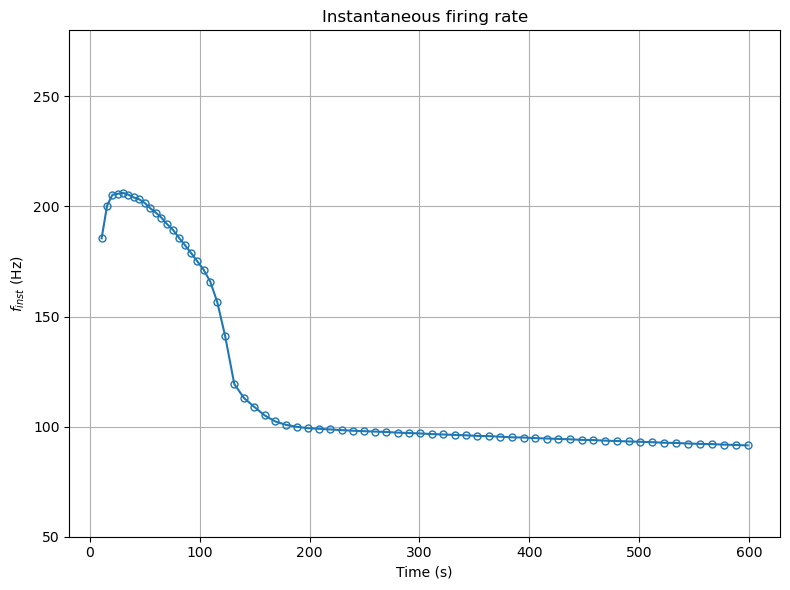

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Detect spikes
thresh = 0.0
spike_times = time[np.where((VS[:-1] < thresh) & (VS[1:] >= thresh))[0]]

# Compute instantaneous firing rate
inst_rate = 1e3 / np.diff(spike_times)
rate_times = spike_times[1:]

# 3) Plot
plt.figure(figsize=(8, 6))
plt.plot(rate_times, inst_rate, marker='o', fillstyle='none', markersize=5)#, drawstyle='steps-post')
plt.xlabel('Time (s)')
plt.ylabel(r'$f_{inst}$ (Hz)')
plt.title('Instantaneous firing rate')
plt.tight_layout()
plt.ylim(50, 280)
plt.grid()
plt.show()
